## Introduction to modelling with RUMnet

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/artefactory/choice-learn/blob/main/notebooks/models/rumnet.ipynb)


En el siguiente notebook se presenta una revisión asociada al paper de Representing Random Utility Choice Models
with Neural Networks usando el dataset de SwissMetro.


## Introducción

### Marco teorico

A continuación, la arquitectura planteada del modelo en el paper:


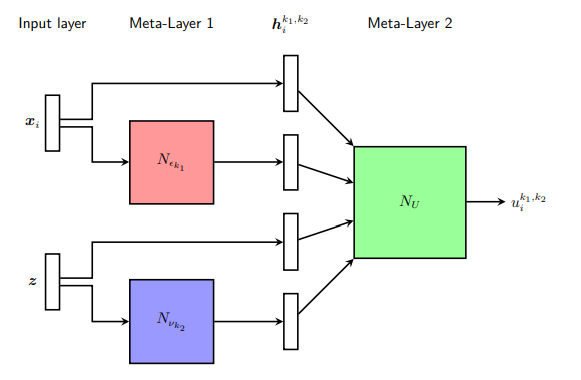

### Input del modelo:

**Importante**: Este modelo tiene 2 implementaciones según las caracteristicas del ordenador, para la revisión de este codigo se utilizo la versión CPURUMNet, ya que antes de todo, se comprueba la presencia de GPU en el computador, y en caso contrario, se importa CPURUMnet como RUMnet.

Se observa que el modelo recibe los siguientes parametros o argumentos:
- ``num_products_features``: "Número de características para describir cada producto. En términos de ChoiceDataset, equivale a la suma de { items_features + contexts_items_features } por producto.",
- ``num_customer_features``: "Número de características para describir cada cliente. En términos de ChoiceDataset, equivale al número de contexts_features.",
- ``width_eps_x``: "Número de neuronas en cada capa densa para la red de codificación de productos.",
- ``depth_eps_x``: "Número de capas densas para la red de codificación de productos.",
- ``heterogeneity_x``: "Número de redes para codificar las características de los productos.",
- ``width_eps_z``: "Número de neuronas en cada capa densa para la red de codificación de clientes.",
- ``depth_eps_z``: "Número de capas densas para la red de codificación de clientes.",
- ``heterogeneity_z``: "Número de redes para codificar las características de los clientes.",
- ``width_u``: "Número de neuronas en cada capa densa para la red de utilidades.",
- ``depth_u``: "Número de capas densas para la red de utilidades.",
- ``tol``: "Tolerancia para los cálculos, aún por implementar.",
- ``optimizer``: "Representación en texto del optimizador a usar. Por defecto es Adam si no se especifica. Debe ser compatible con tf.keras.optimizers.",
- ``lr``: "Tasa de aprendizaje inicial asociada al optimizador.",
- ``add_exit_choice``: "Indica si se debe agregar una opción de salida con utilidad 1. Por defecto es True.",
- ``logmin``: "Valor agregado en cálculos logarítmicos para evitar infinito. Por defecto es 1e-5.",
- ``l2_regularization_coef``: "Coeficiente de regularización L2 para los pesos de las capas densas durante el entrenamiento. Por defecto es 0.0.",
- ``label_smoothing``: "Parámetro opcional para ajustar el suavizado de etiquetas durante el entrenamiento."




### Creación de redes neuronales:

#### Create_ff_network:

Esta función genera una red neuronal densa feed-forward, con profundidad, ancho y funciones de activación asociadas a esta.

```python
def create_ff_network(
    input_shape,
    depth,
    width,
    activation="elu",
    add_last=False,
    l2_regularization_coeff=0.0,
):
    input = tf.keras.layers.Input(shape=input_shape)
    regularizer = tf.keras.regularizers.L2(l2_regularization_coeff)
    out = input
    for _ in range(depth):
        out = tf.keras.layers.Dense(
            width, activation=activation, kernel_regularizer=regularizer, use_bias=True
        )(out)
    if add_last:
        out = tf.keras.layers.Dense(1, activation="linear", use_bias=False)(out)
    return tf.keras.Model(inputs=input, outputs=out)
```

#### recreate_official_nets:
Esta función crea las redes asociadas al modelo, dado cierto ancho, profundidad y heterogeneidad asociada al modelo.

```python
def recreate_official_nets(
    num_products_features,
    x_width,
    x_depth,
    x_eps,
    num_customer_features,
    z_width,
    z_depth,
    z_eps,
    width_u,
    depth_u,
    l2_regularization_coeff=0.0,
):
    # Products and Customers embeddings nets, quiet symmetrical
    products_input = tf.keras.layers.Input(shape=(num_products_features,))
    customer_input = tf.keras.layers.Input(shape=(num_customer_features,))
    x_embeddings = []
    z_embeddings = []

    # Creating independant nets for each heterogeneity
    for _ in range(x_eps):
        x_embedding = create_ff_network(
            input_shape=(num_products_features,),
            depth=x_depth,
            width=x_width,
            l2_regularization_coeff=l2_regularization_coeff,
        )(products_input)
        x_embeddings.append(x_embedding)

    # Creating independant nets for each heterogeneity
    for _ in range(z_eps):
        z_embedding = create_ff_network(
            input_shape=(num_customer_features,),
            depth=z_depth,
            width=z_width,
            l2_regularization_coeff=l2_regularization_coeff,
        )(customer_input)

        z_embeddings.append(z_embedding)

    x_net = tf.keras.Model(inputs=products_input, outputs=x_embeddings, name="X_embedding")
    z_net = tf.keras.Model(inputs=customer_input, outputs=z_embeddings, name="Z_embedding")

    # Utility network
    u_net = create_ff_network(
        input_shape=(
            x_width + z_width + num_products_features + num_customer_features,
        ),  # Input shape from previous nets
        width=width_u,
        depth=depth_u,
        add_last=True,  # Add last for utility
        l2_regularization_coeff=l2_regularization_coeff,
    )

    return x_net, z_net, u_net
```


In [1]:
# Install necessary requirements

# If you run this notebook on Google Colab, or in standalone mode, you need to install the required packages.
# Uncomment the following lines:

# !pip install choice-learn

# If you run the notebook within the GitHub repository, you need to run the following lines, that can skipped otherwise:
import os
import sys

sys.path.append("../../")

In [2]:
import os
# Remove/Add GPU use
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from choice_learn.data import ChoiceDataset
from choice_learn.models import RUMnet
from choice_learn.datasets import load_swissmetro

Notar que hay 2 implementaciones de RUMnet: una CPU-orientada y la otra GPU-orientada,
La importación del modelo correcta es automatica. Tambine se puede importar el modelo directamente con:

```python
from choice_learn.models import CPURUMnet, GPURUMnet
```

Primero, se descarga el data set de swissmetro:

We follow the same data preparation as in the original paper in order to get the exact same results.


Ahora, se crea el Choicedataset a partir del dataset.

In [18]:
dataset = load_swissmetro(as_frame=False, preprocessing="rumnet")

                                    fit models needing them such as Conditional Logit.
                                fit models needing them such as Conditional Logit.


Let's Cross-Validate !
We keep a scikit-learn-like structure.
To avoid creating dependancies, we use a different train/test split code, but the following would totally work:


```python
from sklearn.model_selection import ShuffleSplit

rs = ShuffleSplit(n_splits=5, test_size=.2, random_state=0)

for i, (train_index, test_index) in enumerate(rs.split(dataset.choices)):
    train_dataset = dataset[train_index]
    test_dataset = dataset[test_index]

    model = RUMnet(**args)
    model.instantiate()
    model.fit(train_dataset)
    model.evaluate(test_dataset)
```

We just use a numpy based split, but the core code is the same!

In [20]:
model_args = {
    "num_products_features": 6,
    "num_customer_features": 83,
    "width_eps_x": 20,
    "depth_eps_x": 5,
    "heterogeneity_x": 10,
    "width_eps_z": 20,
    "depth_eps_z": 5,
    "heterogeneity_z": 10,
    "width_u": 20,
    "depth_u": 5,
    "optimizer": "Adam",
    "lr": 0.0002,
    "logmin": 1e-10,
    "label_smoothing": 0.02,
    "callbacks": [],
    "epochs": 140,
    "batch_size": 32,
    "tol": 0,
}

In [5]:
indexes = np.random.permutation(list(range(len(dataset))))

fit_losses = []
test_eval = []
for i in range(5):
    test_indexes = indexes[int(len(indexes) * 0.2 * i):int(len(indexes) * 0.2 * (i + 1))]
    train_indexes = np.concatenate([indexes[:int(len(indexes) * 0.2 * i)],
                                    indexes[int(len(indexes) * 0.2 * (i + 1)):]],
                                   axis=0)

    train_dataset = dataset[train_indexes]
    test_dataset = dataset[test_indexes]

    model = RUMnet(**model_args)
    model.instantiate()
       
    losses = model.fit(train_dataset, val_dataset=test_dataset)
    probas = model.predict_probas(test_dataset)
    eval = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(y_pred=model.predict_probas(test_dataset), y_true=tf.one_hot(test_dataset.choices, 3))
    test_eval.append(eval)
    print(test_eval)

    fit_losses.append(losses)

                                    fit models needing them such as Conditional Logit.
                                fit models needing them such as Conditional Logit.
                                    fit models needing them such as Conditional Logit.
                                fit models needing them such as Conditional Logit.
Epoch 139 Train Loss 0.4926: 100%|██████████| 140/140 [28:46<00:00, 12.33s/it]
                                    fit models needing them such as Conditional Logit.
                                fit models needing them such as Conditional Logit.
                                    fit models needing them such as Conditional Logit.
                                fit models needing them such as Conditional Logit.


[<tf.Tensor: shape=(), dtype=float32, numpy=0.5530202>]


Epoch 139 Train Loss 0.4747: 100%|██████████| 140/140 [31:02<00:00, 13.30s/it] 
                                    fit models needing them such as Conditional Logit.
                                fit models needing them such as Conditional Logit.
                                    fit models needing them such as Conditional Logit.
                                fit models needing them such as Conditional Logit.


[<tf.Tensor: shape=(), dtype=float32, numpy=0.5530202>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5195703>]


Epoch 139 Train Loss 0.4790: 100%|██████████| 140/140 [22:36<00:00,  9.69s/it]
                                    fit models needing them such as Conditional Logit.
                                fit models needing them such as Conditional Logit.
                                    fit models needing them such as Conditional Logit.
                                fit models needing them such as Conditional Logit.


[<tf.Tensor: shape=(), dtype=float32, numpy=0.5530202>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5195703>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5571601>]


Epoch 139 Train Loss 0.4652: 100%|██████████| 140/140 [23:15<00:00,  9.97s/it]
                                    fit models needing them such as Conditional Logit.
                                fit models needing them such as Conditional Logit.
                                    fit models needing them such as Conditional Logit.
                                fit models needing them such as Conditional Logit.


[<tf.Tensor: shape=(), dtype=float32, numpy=0.5530202>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5195703>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5571601>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5734286>]


Epoch 139 Train Loss 0.4524: 100%|██████████| 140/140 [22:51<00:00,  9.80s/it]


[<tf.Tensor: shape=(), dtype=float32, numpy=0.5530202>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5195703>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5571601>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5734286>, <tf.Tensor: shape=(), dtype=float32, numpy=0.58028436>]


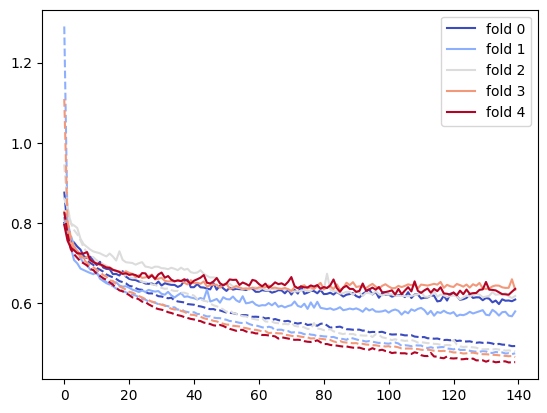

In [6]:
cmap = plt.cm.coolwarm
colors = [cmap(j / 4) for j in range(5)]
for i in range(len(fit_losses)):
    plt.plot(fit_losses[i]["train_loss"], c=colors[i], linestyle="--")
    plt.plot(fit_losses[i]["test_loss"], label=f"fold {i}", c=colors[i])
plt.legend()

In [7]:
model.evaluate(test_dataset)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5803154>

In [8]:
print("Average LogLikeliHood on test:", np.mean(test_eval))

Average LogLikeliHood on test: 0.5566927


## A larger and more complex dataset: Expedia ICDM 2013
The RUMnet paper benchmarks the model on a second dataset. If you want to use it you need to download the file from [Kaggle](https://www.kaggle.com/c/expedia-personalized-sort) and place the train.csv file in the folder choice_learn/datasets/data with the name expedia.csv.

In [ ]:
from choice_learn.datasets import load_expedia

# It takes some time...
expedia_dataset = load_expedia(preprocessing="rumnet")

In [ ]:
test_dataset = expedia_dataset[int(len(expedia_dataset)*0.8):]
train_dataset = expedia_dataset[:int(len(expedia_dataset)*0.8)]

model_args = {
    "num_products_features": 46,
    "num_customer_features": 84,
    "width_eps_x": 10,
    "depth_eps_x": 3,
    "heterogeneity_x": 5,
    "width_eps_z": 10,
    "depth_eps_z": 3,
    "heterogeneity_z": 5,
    "width_u": 10,
    "depth_u": 3,
    "tol": 0,
    "optimizer": "Adam",
    "lr": 0.001,
    "logmin": 1e-10,
    "label_smoothing": 0.02,
    "callbacks": [],
    "epochs": 15,
    "batch_size": 128,
    "tol": 1e-5,
}
model = RUMnet(**model_args)
model.instantiate()

losses = model.fit(train_dataset, val_dataset=test_dataset)
probas = model.predict_probas(test_dataset)
test_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(y_pred=model.predict_probas(test_dataset), y_true=tf.one_hot(test_dataset.choices, 39))

print(test_loss)